<a href="https://colab.research.google.com/github/GGADS10/C_digo_CVM/blob/main/C%C3%B3digo_em_Phyton_para_Buscar_na_CVM_a_Rentabilidade_dos_Fundos_de_Investimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Volatilidade Anual do fundo: 12.94%
Rentabilidade Acumulada Atual do fundo: 8.04%
[*********************100%%**********************]  1 of 1 completed
Volatilidade Anual do IBOV: 17.60%
Retorno Acumulado do IBOV: 13.41%


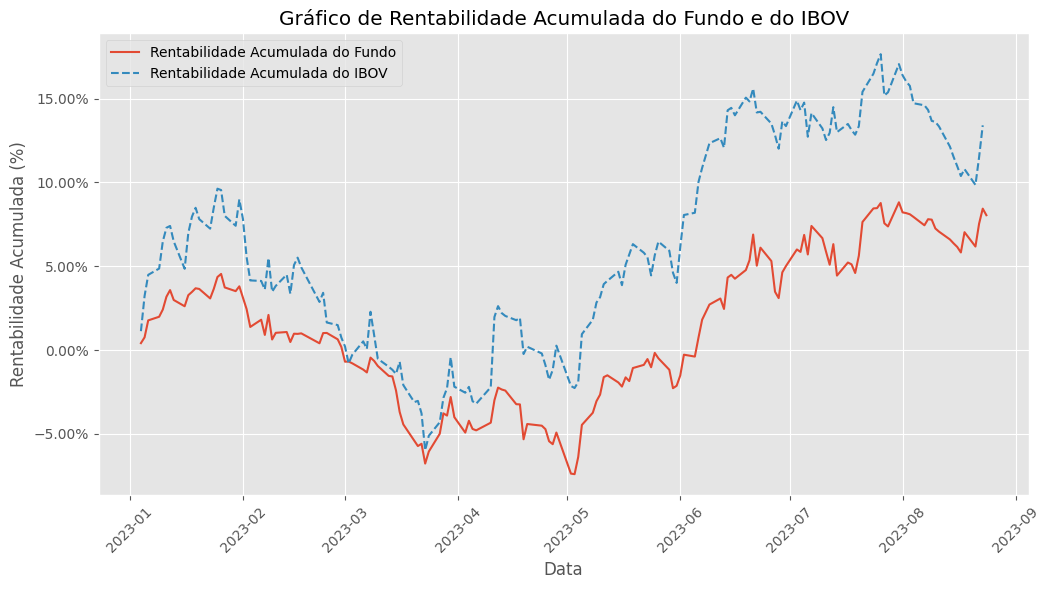

In [4]:


import requests
import pandas as pd
from io import BytesIO
import zipfile
import matplotlib.pyplot as fig
import numpy as np
import scipy.optimize as solver
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
yf.pdr_override()



# URLs dos arquivos ZIP
urls = [
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202301.zip",
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202302.zip",
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202303.zip",
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202304.zip",
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202305.zip",
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202306.zip",
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202307.zip",
    "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202308.zip"
]

# Inicializar um DataFrame vazio para armazenar os dados combinados
combined_df = pd.DataFrame()

for url in urls:
    # Enviar uma solicitação HTTP GET para a URL e obter o conteúdo do arquivo ZIP
    response = requests.get(url)

    # Verificar se o download foi bem-sucedido (status 200)
    if response.status_code == 200:
        # Ler o conteúdo do arquivo ZIP a partir dos dados binários
        zip_content = BytesIO(response.content)

        # Extrair o arquivo ZIP
        with zipfile.ZipFile(zip_content, "r") as zip_file:
            # Assumindo que há apenas um arquivo CSV dentro do ZIP
            csv_file_name = zip_file.namelist()[0]

            # Ler o conteúdo do arquivo CSV diretamente em um DataFrame pandas
            df = pd.read_csv(zip_file.open(csv_file_name), sep=";")

            # Concatenar o DataFrame lido com o DataFrame combinado
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    else:
        print(f"Erro ao fazer o download do arquivo ZIP: {url}")

# Defina o CNPJ Do fundo e as datas de início e fim para o período desejado
fundo = "26.680.221/0001-41"
inicio = pd.to_datetime('2023-01-03')
fim = pd.to_datetime('2023-08-24')

# Converter a coluna 'DT_COMPTC' para objetos Timestamp
combined_df['DT_COMPTC'] = pd.to_datetime(combined_df['DT_COMPTC'])

# Crie um filtro para selecionar as linhas dentro do período desejado
filtro_data = (combined_df['DT_COMPTC'] >= inicio) & (combined_df['DT_COMPTC'] <= fim)


# Aplique o filtro de datas ao DataFrame
dados_filtrados_por_data = combined_df[filtro_data]

# Filtrar os dados da coluna "CNPJ_FUNDO" com valor igual a "fundo"
filtro = dados_filtrados_por_data['CNPJ_FUNDO'] == fundo

# Criar um novo DataFrame com os dados filtrados por data e CNPJ do fundo
dados_filtrados_por_data_e_cnpj = dados_filtrados_por_data[filtro]

# Lista das colunas que deseja excluir
colunas_para_excluir = ['VL_TOTAL', 'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST']

# Use o método .drop() para excluir as colunas
dados_filtrados_por_data_e_cnpj = dados_filtrados_por_data_e_cnpj.drop(columns=colunas_para_excluir)

# Obter o número de linhas do DataFrame resultante
num_linhas = dados_filtrados_por_data_e_cnpj.shape[0]

# Calcular os retornos percentuais diários
dados_filtrados_por_data_e_cnpj['Retornos'] = dados_filtrados_por_data_e_cnpj['VL_QUOTA'].pct_change()

# Remover valores nulos dos retornos percentuais diários
dados_filtrados_por_data_e_cnpj = dados_filtrados_por_data_e_cnpj.dropna(subset=['Retornos'])

# Calcular o desvio padrão dos retornos
desvio_padrao_retornos = dados_filtrados_por_data_e_cnpj['Retornos'].std()

# Calcular a volatilidade anual (desvio padrão médio) dos retornos
volatilidade_anual = desvio_padrao_retornos * np.sqrt(252) * 100

# Arredondar a volatilidade para duas casas decimais e adicionar o sinal de "%"
volatilidade_formatada = round(volatilidade_anual, 2)

# Exibir a volatilidade anual formatada
print(f"Volatilidade Anual do fundo: {volatilidade_formatada:.2f}%")

# Calcular os retornos acumulados a partir dos retornos diários
dados_filtrados_por_data_e_cnpj['Retornos Acumulados'] = (1 + dados_filtrados_por_data_e_cnpj['Retornos']).cumprod() - 1

# Último valor da rentabilidade acumulada (valor atual)
rentabilidade_atual = dados_filtrados_por_data_e_cnpj['Retornos Acumulados'].iloc[-1] * 100

# Imprimir o valor da rentabilidade acumulada atual do fundo com o símbolo de porcentagem (%)
print(f"Rentabilidade Acumulada Atual do fundo: {rentabilidade_atual:.2f}%")

# URL dos IBOV usando as mesmas datas
ibov = yf.download('^BVSP', start=inicio, end=fim)['Adj Close']

# Calcular os retornos diários do IBOV
ibov_retorno = ibov.pct_change()

# Calcular o desvio padrão dos retornos diários do IBOV
desvio_padrao_ibov = ibov_retorno.std()

# Calcular a volatilidade anual (desvio padrão médio) dos retornos
volatilidade_anual_ibov = desvio_padrao_ibov * np.sqrt(252) * 100

# Arredondar a volatilidade para duas casas decimais e adicionar o sinal de "%"
volatilidade_formatada_ibov = round(volatilidade_anual_ibov, 2)

# Exibir a volatilidade anual do IBOV formatada
print(f"Volatilidade Anual do IBOV: {volatilidade_formatada_ibov:.2f}%")

# Remover valores nulos dos retornos percentuais diários
ibov_retorno = ibov_retorno.dropna()

# Calcular os retornos acumulados a partir dos retornos diários
ibov_retorno_acumulado = (1 + ibov_retorno).cumprod() - 1

# Multiplicar por 100 para expressar como porcentagem
ibov_retorno_acumulado = ibov_retorno_acumulado * 100

# Calcular o retorno acumulado do IBOV em porcentagem
ibov_retorno_acumulado = (1 + ibov_retorno).cumprod() - 1
ibov_retorno_acumulado = ibov_retorno_acumulado * 100

# Imprimir o retorno acumulado do IBOV
print(f"Retorno Acumulado do IBOV: {ibov_retorno_acumulado.iloc[-1]:.2f}%")

# Plotar o gráfico de rentabilidade acumulada do fundo e do IBOV
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.plot(dados_filtrados_por_data_e_cnpj['DT_COMPTC'], dados_filtrados_por_data_e_cnpj['Retornos Acumulados'] * 100, label='Rentabilidade Acumulada do Fundo')
plt.plot(ibov_retorno_acumulado.index, ibov_retorno_acumulado, label='Rentabilidade Acumulada do IBOV', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Rentabilidade Acumulada (%)')
plt.title('Gráfico de Rentabilidade Acumulada do Fundo e do IBOV')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))  # Formatador de rótulo de porcentagem com duas casas decimais
plt.xticks(rotation=45)
plt.legend()
plt.show()
